In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM, SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load dataset
file_path = r'C:\Users\aalaz\MastersProjectSource\AWID.csv'
df = pd.read_csv(file_path)

In [3]:
# Display dataset head
print("Dataset Head:\n", df.head())

Dataset Head:
    Unnamed: 0  frame.interface_id  frame.offset_shift  frame.time_epoch  \
0          26                   0                 0.0      1.393661e+09   
1          38                   0                 0.0      1.393661e+09   
2          84                   0                 0.0      1.393661e+09   
3         101                   0                 0.0      1.393661e+09   
4         112                   0                 0.0      1.393661e+09   

   frame.time_delta  frame.time_delta_displayed  frame.time_relative  \
0          0.012404                    0.012404             0.345648   
1          0.008836                    0.008836             0.456882   
2          0.020195                    0.020195             0.843532   
3          0.001847                    0.001847             1.050226   
4          0.000730                    0.000730             1.165574   

   frame.len  frame.cap_len  frame.marked  ...  wlan.duration  \
0        148            148         

In [4]:
# Display dataset description
print("\nDataset Description:\n", df.describe(include='all'))


Dataset Description:
           Unnamed: 0  frame.interface_id  frame.offset_shift  \
count   2.111890e+05            211189.0            211189.0   
unique           NaN                 NaN                 NaN   
top              NaN                 NaN                 NaN   
freq             NaN                 NaN                 NaN   
mean    1.037811e+06                 0.0                 0.0   
std     4.650402e+05                 0.0                 0.0   
min     2.600000e+01                 0.0                 0.0   
25%     6.464510e+05                 0.0                 0.0   
50%     1.236439e+06                 0.0                 0.0   
75%     1.420527e+06                 0.0                 0.0   
max     1.795538e+06                 0.0                 0.0   

        frame.time_epoch  frame.time_delta  frame.time_delta_displayed  \
count       2.111890e+05     211189.000000               211189.000000   
unique               NaN               NaN                  

In [5]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Unnamed: 0            0
frame.interface_id    0
frame.offset_shift    0
frame.time_epoch      0
frame.time_delta      0
                     ..
wlan.bssid            0
wlan.frag             0
wlan.seq              0
wlan.fcs_good         0
class                 0
Length: 84, dtype: int64


In [6]:
# Separate features and target
target = 'class'
features = df.columns.drop([target])

X = df[features]
y = df[target]

In [7]:
# Identify non-numeric columns
non_numeric_columns = X.select_dtypes(exclude=['number']).columns
print("\nNon-numeric columns before encoding:\n", non_numeric_columns)


Non-numeric columns before encoding:
 Index(['radiotap.present.reserved', 'wlan.fc.type_subtype', 'wlan.fc.ds',
       'wlan.ra', 'wlan.da', 'wlan.ta', 'wlan.sa', 'wlan.bssid'],
      dtype='object')


In [8]:
# Convert non-numeric columns to numeric using Label Encoding
label_encoders = {}
for column in non_numeric_columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le
    print(f"Encoded column: {column}")

C:\Users\aalaz\AppData\Local\Temp\ipykernel_668\13220238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column].astype(str))
C:\Users\aalaz\AppData\Local\Temp\ipykernel_668\13220238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column].astype(str))
C:\Users\aalaz\AppData\Local\Temp\ipykernel_668\13220238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Encoded column: radiotap.present.reserved
Encoded column: wlan.fc.type_subtype
Encoded column: wlan.fc.ds
Encoded column: wlan.ra
Encoded column: wlan.da
Encoded column: wlan.ta
Encoded column: wlan.sa
Encoded column: wlan.bssid


In [9]:
# Handle missing values: filling with the mean of the column
X = X.apply(lambda col: col.fillna(col.mean()), axis=0)

In [10]:
# Check again for missing values after handling
print("\nMissing Values after handling:\n", X.isnull().sum())


Missing Values after handling:
 Unnamed: 0            0
frame.interface_id    0
frame.offset_shift    0
frame.time_epoch      0
frame.time_delta      0
                     ..
wlan.sa               0
wlan.bssid            0
wlan.frag             0
wlan.seq              0
wlan.fcs_good         0
Length: 83, dtype: int64


In [11]:
# Feature Engineering specific to rogue access points
# Check if 'ssid' and 'bssid' columns exist
if 'ssid' in X.columns and 'bssid' in X.columns:
    X['is_rogue_ssid'] = X['ssid'].apply(lambda x: 1 if 'rogue' in str(x).lower() else 0)
    X['is_rogue_bssid'] = X['bssid'].apply(lambda x: 1 if 'rogue' in str(x).lower() else 0)
else:
    print("Columns 'ssid' and/or 'bssid' not found in the dataset. Skipping related feature engineering.")

Columns 'ssid' and/or 'bssid' not found in the dataset. Skipping related feature engineering.


In [12]:
# Add other domain-specific features for rogue access points
# Ensure columns exist before using them
if 'signal_strength' in X.columns and 'num_packets' in X.columns and 'duration' in X.columns:
    X['signal_strength_diff'] = X['signal_strength'].diff().fillna(0)
    X['packet_rate'] = X['num_packets'] / (X['duration'] + 1)
else:
    print("Columns 'signal_strength', 'num_packets', and/or 'duration' not found in the dataset. Skipping related feature engineering.")

Columns 'signal_strength', 'num_packets', and/or 'duration' not found in the dataset. Skipping related feature engineering.


In [13]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Update features list after transformation
features = X.columns

In [15]:
# Feature Selection - Selecting top k features using ANOVA F-test
k = 10
selector = SelectKBest(f_classif, k=k)
X_new = selector.fit_transform(X_scaled, y)

C:\Users\aalaz\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 1  2  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 44 45 48 51 52 53 54 55 56 57 58 59
 61 62 64 73 82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\aalaz\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [16]:
# Get selected features
selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

Selected Features: ['radiotap.datarate', 'radiotap.channel.type.cck', 'radiotap.channel.type.ofdm', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.pwrmgt', 'wlan.fc.protected', 'wlan.duration', 'wlan.ta']


In [17]:
# DataFrame for selected features
X_selected = pd.DataFrame(X_new, columns=selected_features)

In [18]:
# Display head of the selected features DataFrame
print("\nSelected Features DataFrame Head:\n", X_selected.head())


Selected Features DataFrame Head:
    radiotap.datarate  radiotap.channel.type.cck  radiotap.channel.type.ofdm  \
0          -0.580098                   0.578077                   -0.578077   
1          -0.580098                   0.578077                   -0.578077   
2          -0.580098                   0.578077                   -0.578077   
3          -0.580098                   0.578077                   -0.578077   
4           1.785992                  -1.729872                    1.729872   

   wlan.fc.type  wlan.fc.subtype  wlan.fc.ds  wlan.fc.pwrmgt  \
0     -1.436027         0.604326   -1.258937       -0.379578   
1     -1.436027        -0.218081   -1.258937       -0.379578   
2     -1.436027         0.604326   -1.258937       -0.379578   
3     -1.436027         0.604326   -1.258937       -0.379578   
4      0.696366         0.604326    1.113495       -0.379578   

   wlan.fc.protected  wlan.duration   wlan.ta  
0          -1.404660      -0.958248  0.031756  
1       

In [19]:
# Plotting the selected features with their scores
feature_scores = selector.scores_[selector.get_support()]
sorted_indices = np.argsort(feature_scores)
sorted_scores = feature_scores[sorted_indices]
sorted_features = np.array(selected_features)[sorted_indices]

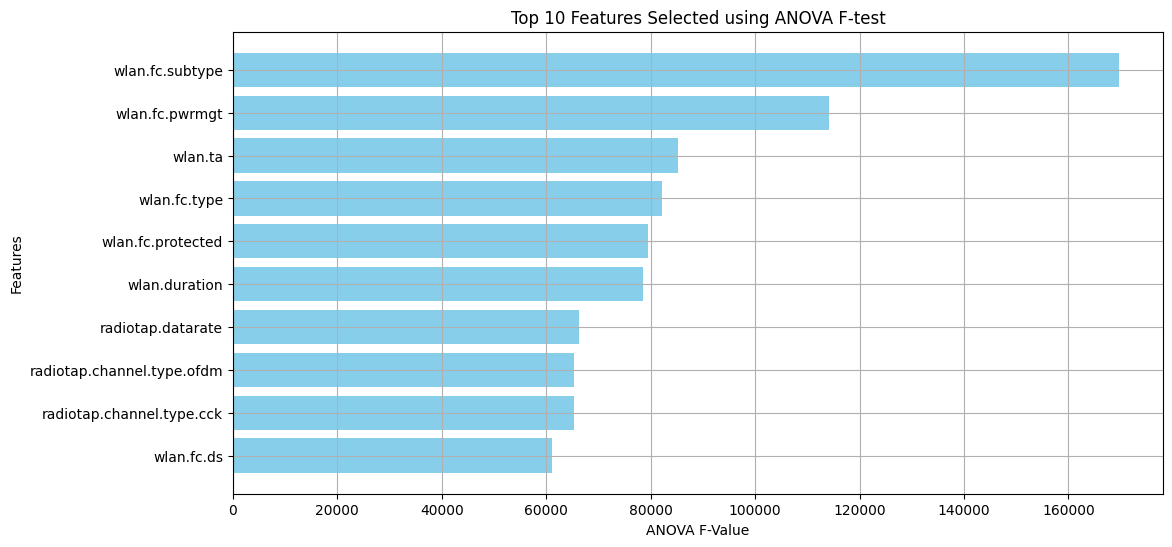

In [20]:
# Plotting the selected features with their scores
feature_scores = selector.scores_[selector.get_support()]
sorted_indices = np.argsort(feature_scores)
sorted_scores = feature_scores[sorted_indices]
sorted_features = np.array(selected_features)[sorted_indices]

plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_scores, color='skyblue')
plt.xlabel('ANOVA F-Value')
plt.ylabel('Features')
plt.title('Top 10 Features Selected using ANOVA F-test')
plt.grid(True)
plt.show()

In [21]:
# Display detailed information about selected features
for feature, score in zip(selected_features, feature_scores):
    print(f"Feature: {feature}, ANOVA F-Value: {score}")

Feature: radiotap.datarate, ANOVA F-Value: 66279.71272229256
Feature: radiotap.channel.type.cck, ANOVA F-Value: 65390.93395337472
Feature: radiotap.channel.type.ofdm, ANOVA F-Value: 65390.93395337472
Feature: wlan.fc.type, ANOVA F-Value: 82224.29203234994
Feature: wlan.fc.subtype, ANOVA F-Value: 169615.73185398892
Feature: wlan.fc.ds, ANOVA F-Value: 61197.28128330335
Feature: wlan.fc.pwrmgt, ANOVA F-Value: 114173.26301420841
Feature: wlan.fc.protected, ANOVA F-Value: 79475.48630075669
Feature: wlan.duration, ANOVA F-Value: 78489.48271728816
Feature: wlan.ta, ANOVA F-Value: 85321.05154606918


In [22]:
# Ensure y is of integer type
if y.dtype == 'O':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)

In [23]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [24]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted') * 100:.2f}%")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted') * 100:.2f}%")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted') * 100:.2f}%")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


--- Isolation Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.87      0.29      7778
           1       0.00      0.00      0.00      7687
           2       0.00      0.00      0.00      9435
           3       0.00      0.00      0.00     17338

    accuracy                           0.16     42238
   macro avg       0.04      0.22      0.07     42238
weighted avg       0.03      0.16      0.05     42238

Confusion Matrix:
[[ 6783   995     0     0]
 [ 7684     3     0     0]
 [ 9423    12     0     0]
 [14336  3002     0     0]]
Accuracy: 16.07%
Precision: 3.28%
Recall: 16.07%
F1 Score: 5.44%


C:\Users\aalaz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aalaz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aalaz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aalaz\anaconda3\Lib\site-packag

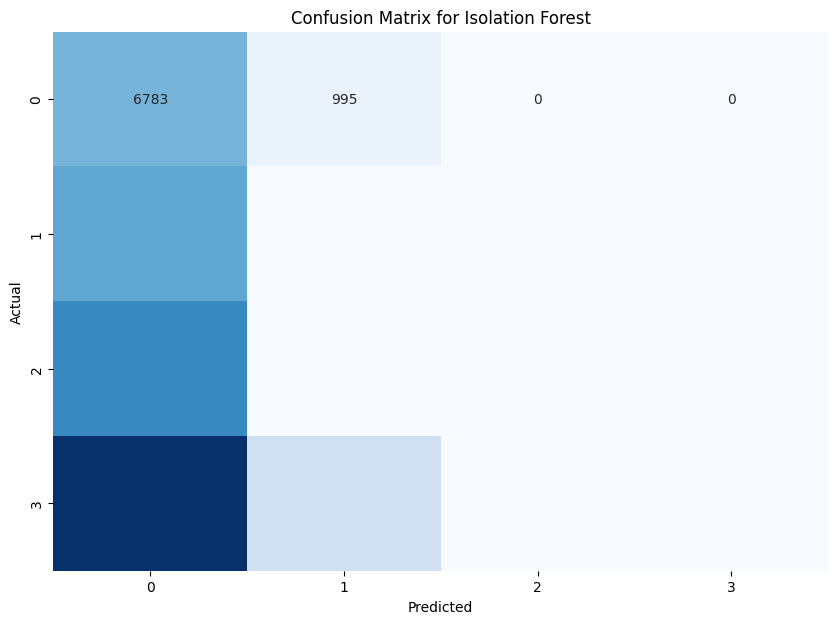

In [28]:
# Implementing Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
isolation_forest.fit(X_train)
y_pred_if_test = isolation_forest.predict(X_test)
y_pred_if_test = np.where(y_pred_if_test == 1, 0, 1)
evaluate_model(y_test, y_pred_if_test, 'Isolation Forest')


--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      7778
           1       0.89      0.99      0.94      7687
           2       1.00      1.00      1.00      9435
           3       0.97      0.95      0.96     17338

    accuracy                           0.97     42238
   macro avg       0.96      0.97      0.97     42238
weighted avg       0.97      0.97      0.97     42238

Confusion Matrix:
[[ 7346     0     0   432]
 [    0  7576     0   111]
 [    0     0  9435     0]
 [    7   924     1 16406]]
Accuracy: 96.51%
Precision: 96.69%
Recall: 96.51%
F1 Score: 96.54%


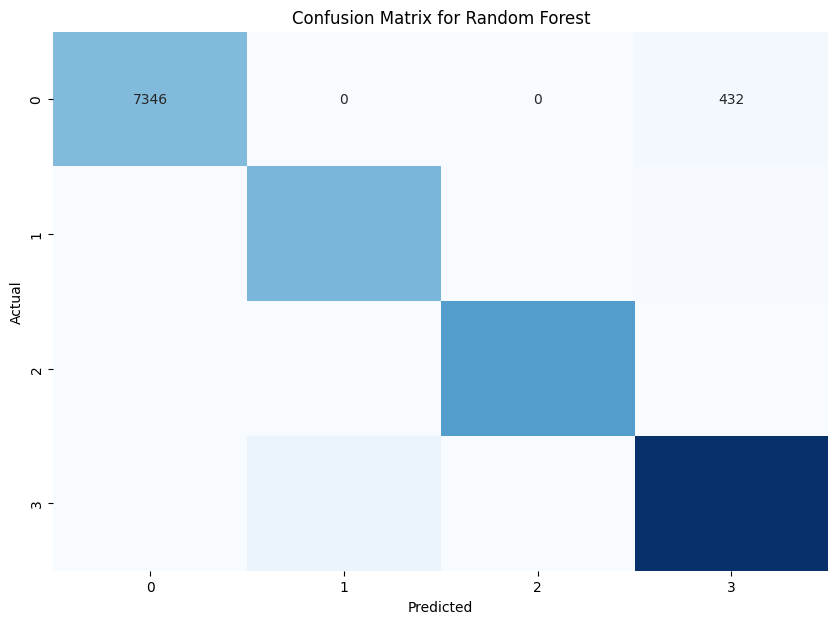

In [28]:
# Random Forest Model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
evaluate_model(y_test, y_pred_rf, 'Random Forest')


--- One-Class SVM ---
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.99      0.35      7778
           1       0.87      0.68      0.76      7687
           2       0.00      0.00      0.00      9435
           3       0.00      0.00      0.00     17338

    accuracy                           0.31     42238
   macro avg       0.27      0.42      0.28     42238
weighted avg       0.20      0.31      0.20     42238

Confusion Matrix:
[[ 7689    89     0     0]
 [ 2456  5231     0     0]
 [ 9423    12     0     0]
 [16634   704     0     0]]
Accuracy: 30.59%
Precision: 19.68%
Recall: 30.59%
F1 Score: 20.31%


C:\Users\aalaz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aalaz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aalaz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aalaz\anaconda3\Lib\site-packag

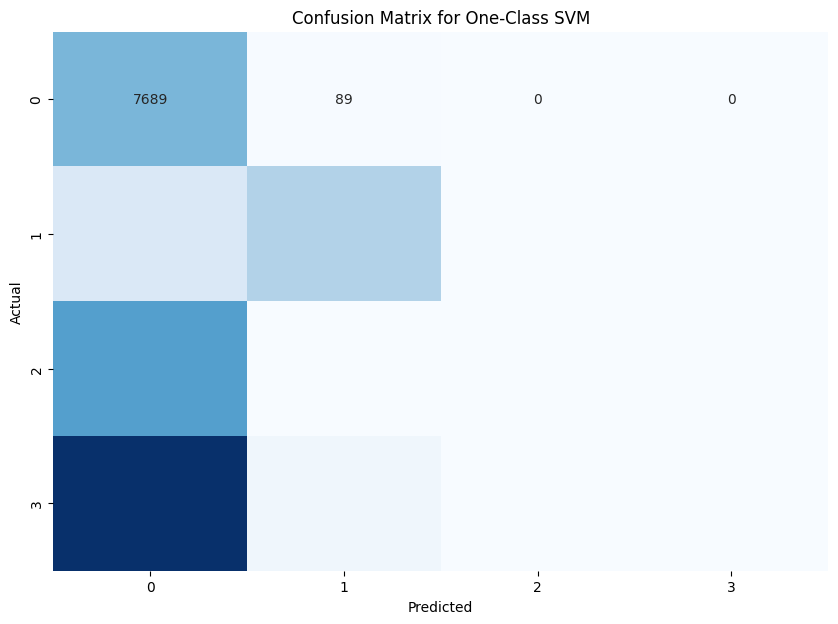

In [30]:
# One-Class SVM Model Integration
one_class_svm = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')
one_class_svm.fit(X_train)
y_pred_ocsvm = one_class_svm.predict(X_test)
y_pred_ocsvm = np.where(y_pred_ocsvm == 1, 0, 1)  # Adjusting labels for evaluation

# Evaluate the model
evaluate_model(y_test, y_pred_ocsvm, 'One-Class SVM')


--- Supervised SVM ---
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      7778
           1       0.93      0.92      0.93      7687
           2       1.00      1.00      1.00      9435
           3       0.92      0.95      0.94     17338

    accuracy                           0.94     42238
   macro avg       0.95      0.94      0.94     42238
weighted avg       0.94      0.94      0.94     42238

Confusion Matrix:
[[ 6893     0     0   885]
 [  109  7110     0   468]
 [    0     0  9435     0]
 [  367   506     1 16464]]
Accuracy: 94.47%
Precision: 94.48%
Recall: 94.47%
F1 Score: 94.46%


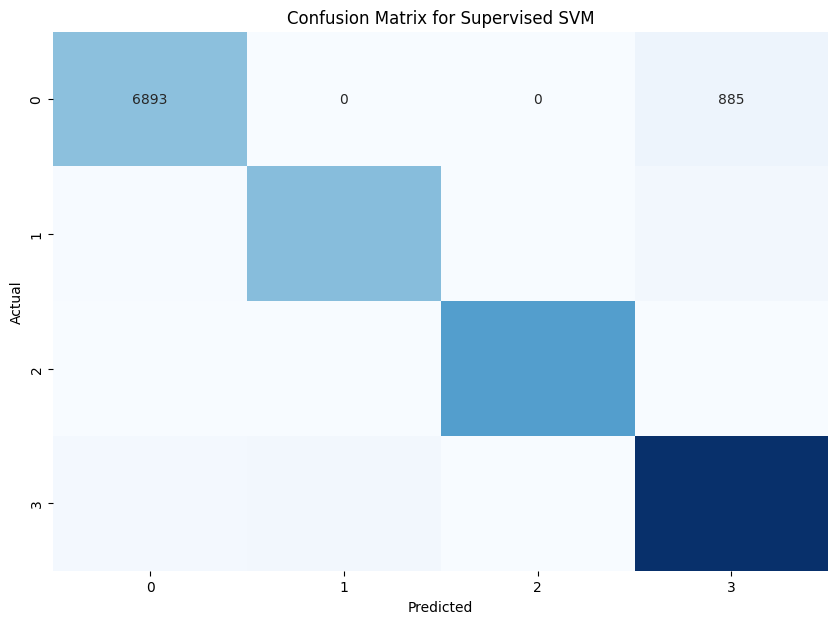

In [29]:
#Supervised SVM Model Integration
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
evaluate_model(y_test, y_pred_svm, 'Supervised SVM')

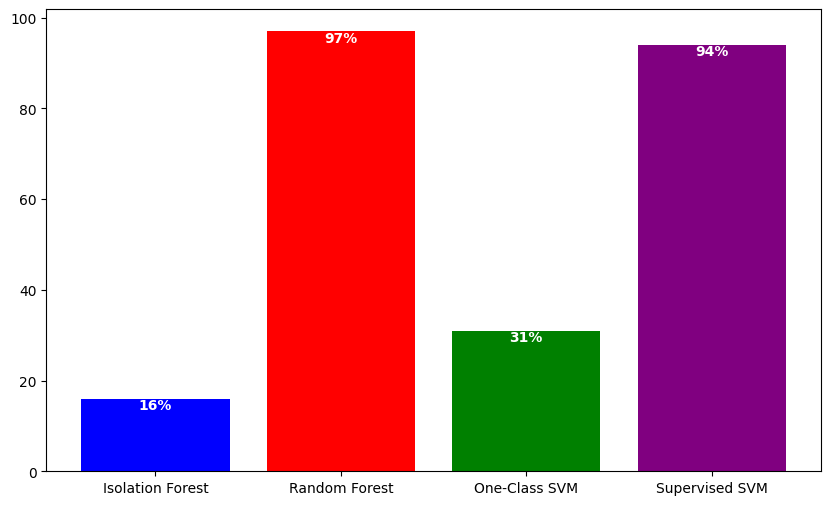

In [37]:
#Bar Graph to display accuracy scores for all 4 models
accuracy_scores = {
    'Isolation Forest': 16,
    'Random Forest': 97,     
    'One-Class SVM': 31,     
    'Supervised SVM': 94     
}

models = list(accuracy_scores.keys())
accuracies = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'red', 'green', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 3, f'{yval}%', ha='center', va='bottom', color='white', weight='bold')
plt.show()

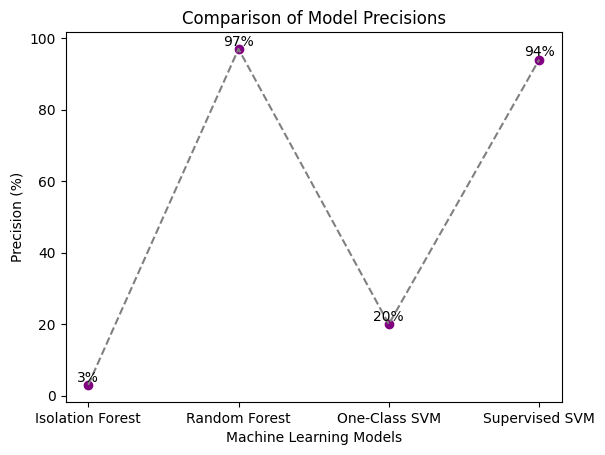

In [36]:
# Dot Graph to display precision scores for all 4 models
precision_scores = {
    'Isolation Forest': 3,  
    'Random Forest': 97,     
    'One-Class SVM': 20,     
    'Supervised SVM': 94     
}
models = list(precision_scores.keys())
precisions = list(precision_scores.values())

for i, (model, precision) in enumerate(zip(models, precisions)):
    plt.scatter(model, precision, color='purple')
    plt.text(model, precision + 1, f'{precision}%', horizontalalignment='center', color='black', fontsize=10)
plt.plot(models, precisions, color='gray', linestyle='--')

plt.xlabel('Machine Learning Models')
plt.ylabel('Precision (%)')
plt.title('Comparison of Model Precisions')
  

plt.show()

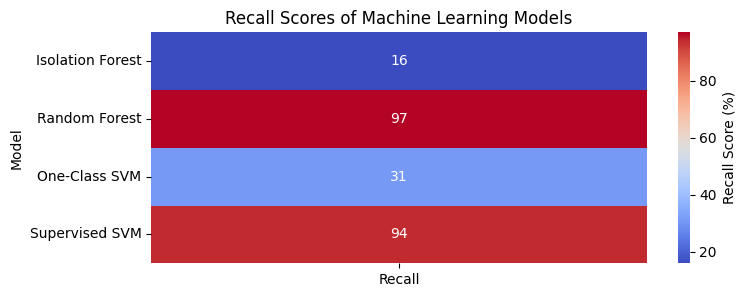

In [39]:
#heatmap to display the recall scores of the 4 models
data = {
    'Model': ['Isolation Forest', 'Random Forest', 'One-Class SVM', 'Supervised SVM'],
    'Recall': [16, 97, 31, 94]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
plt.figure(figsize=(8, 3))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='g', cbar_kws={'label': 'Recall Score (%)'})
plt.title('Recall Scores of Machine Learning Models')
plt.show()

In [40]:
# Saving the preprocessed dataset with selected features to a new CSV file
preprocessed_file_path = r'C:\Users\aalaz\MastersProjectSource\AWID_preprocessedDataset.csv'
X_selected.to_csv(preprocessed_file_path, index=False)
print(f"\nPreprocessed dataset with selected features saved to: {preprocessed_file_path}")


Preprocessed dataset with selected features saved to: C:\Users\aalaz\MastersProjectSource\AWID_preprocessedDataset.csv
